In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

In [3]:
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)

100%|██████████| 50/50 [00:05<00:00,  8.93it/s, epoch=4/4, avg_epoch_loss=0.839]


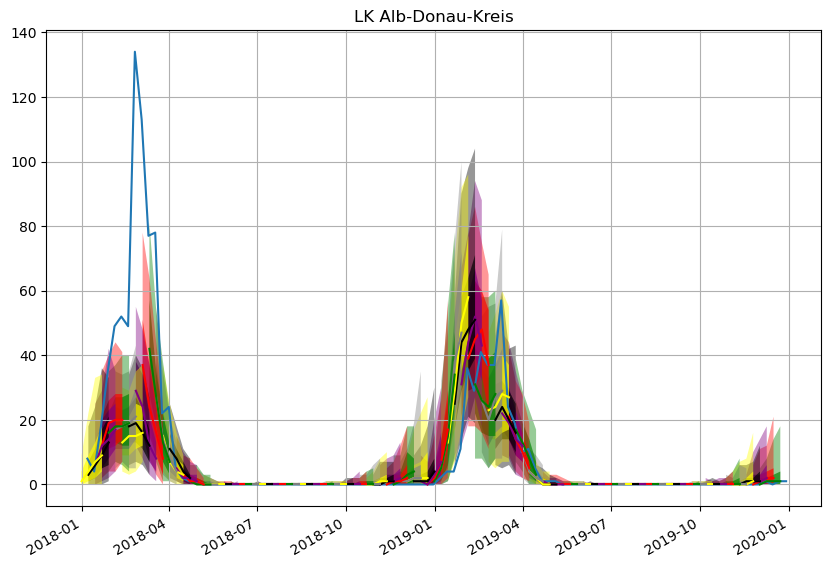

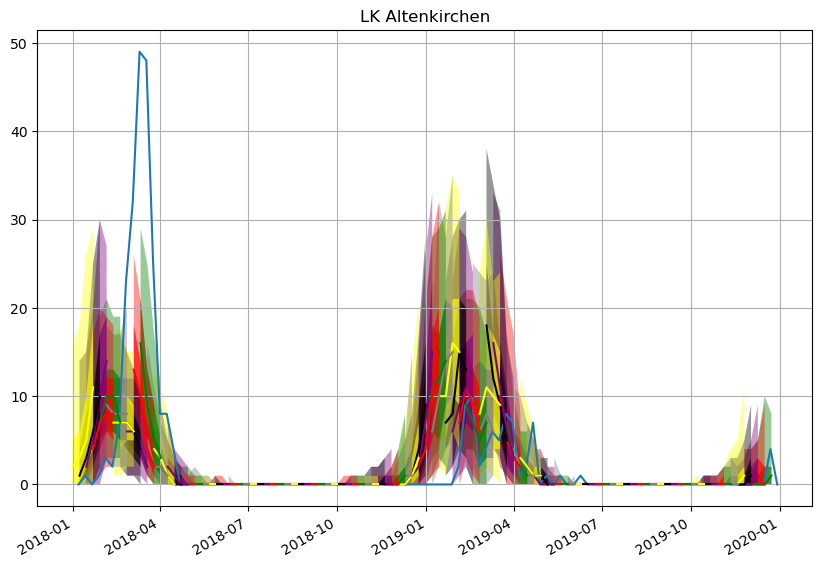

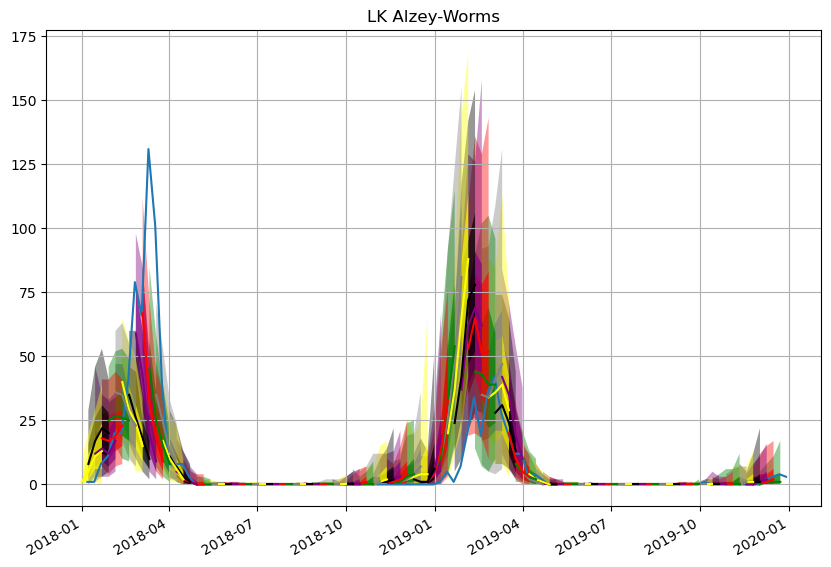

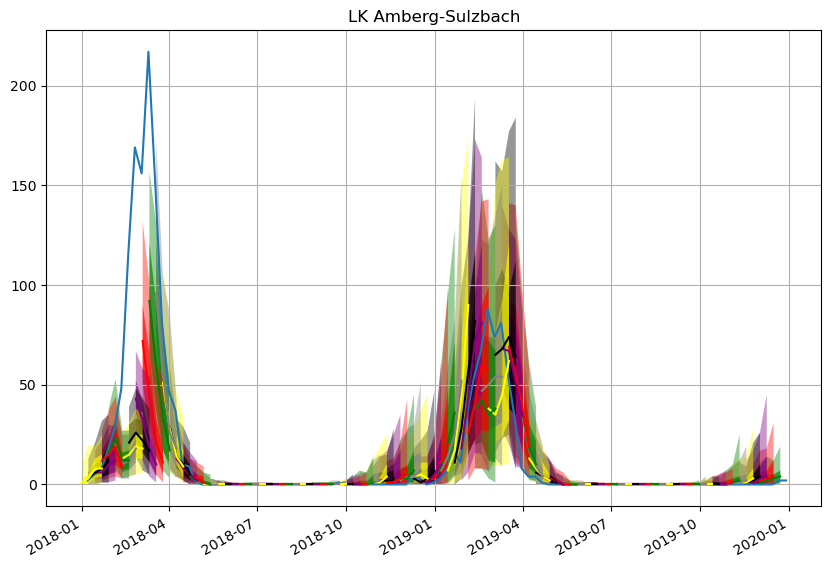

In [4]:
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"] * windows_per_location
    # Iterate through the correct index by changing the range with [windows_per_location]
    for k in range(0 + windows_per_location*locations.index(location),
                   windows_per_location + windows_per_location*locations.index(location)):
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

## Splitting the Forecasts into their week ahead composition

In [5]:
one_week_ahead_forecasts=[]
for location in locations:
    start_date_list = []
    # define the index of the time wise first forecast point
    first_time_point_of_location = windows_per_location + windows_per_location*locations.index(location)-1
    # save the array corresponding to the first week 
    weekly_samples_array = forecasts[first_time_point_of_location].samples[:,:1]
    # also append the time wise first [start_date] to [start_date_list]
    start_date_list.append(forecasts[first_time_point_of_location].start_date)
    for k in range(first_time_point_of_location - 1,
                   first_time_point_of_location - windows_per_location, -1):
        
        weekly_samples_array = np.concatenate((weekly_samples_array, forecasts[k].samples[:, :1]), axis=1)
        start_date_list.append(forecasts[k].start_date)
    
    one_week_ahead_forecasts.append(gluonts.model.forecast.SampleForecast(
        info=forecasts[first_time_point_of_location].info,
        item_id=forecasts[first_time_point_of_location].item_id,
        samples=weekly_samples_array,
        start_date=min(start_date_list)))

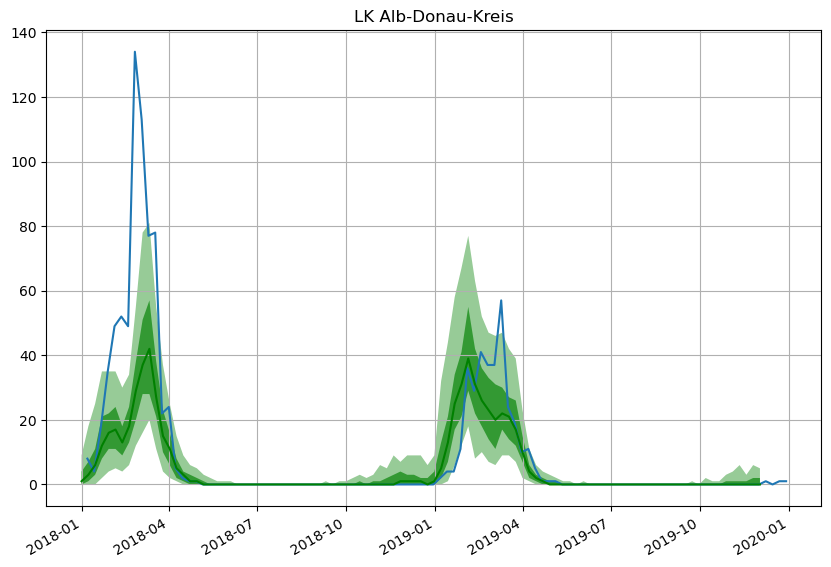

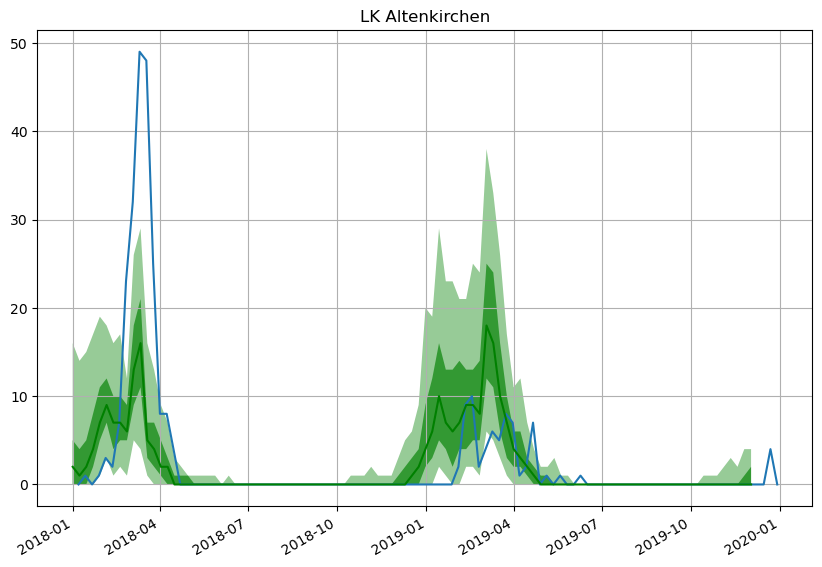

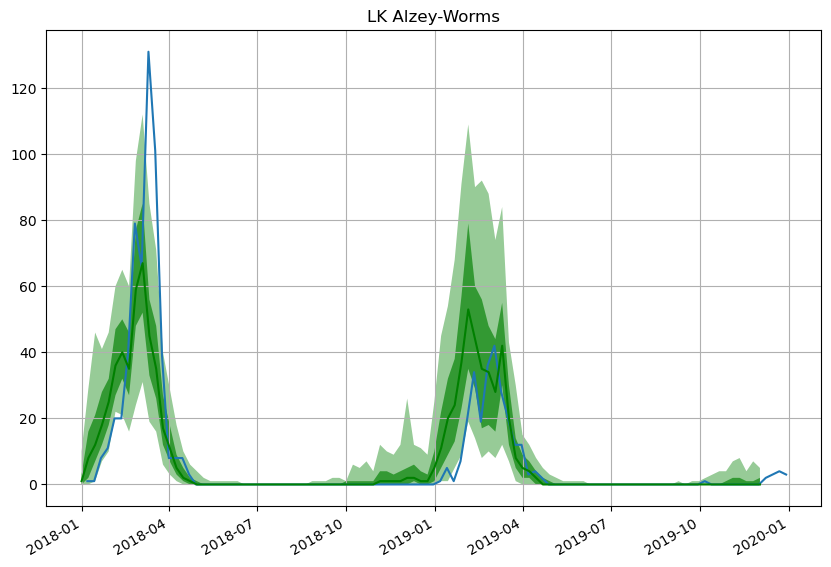

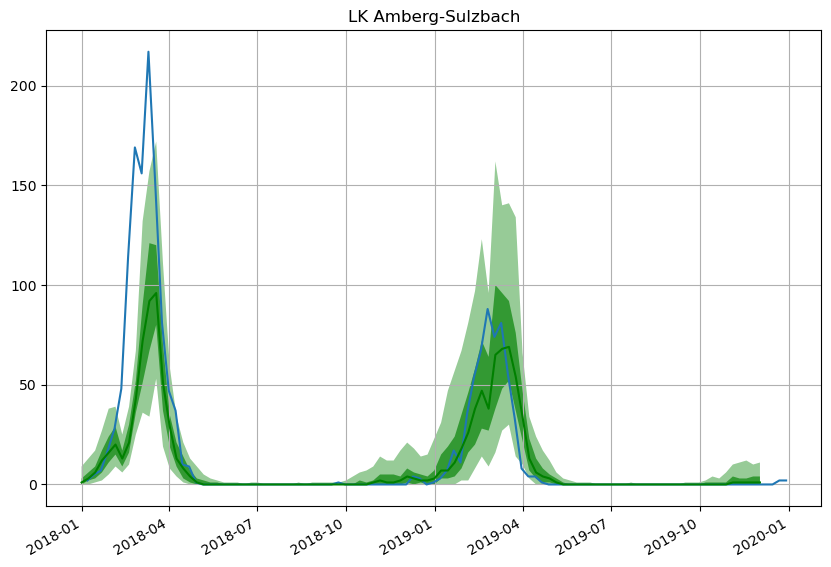

In [6]:
# PLot the Splitted Forecasts for each location
for location in locations[:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"]
    forecast_entry = one_week_ahead_forecasts[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

### Use the Implementation within model.py

In [7]:
two_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)
one_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)
three_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)
four_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)

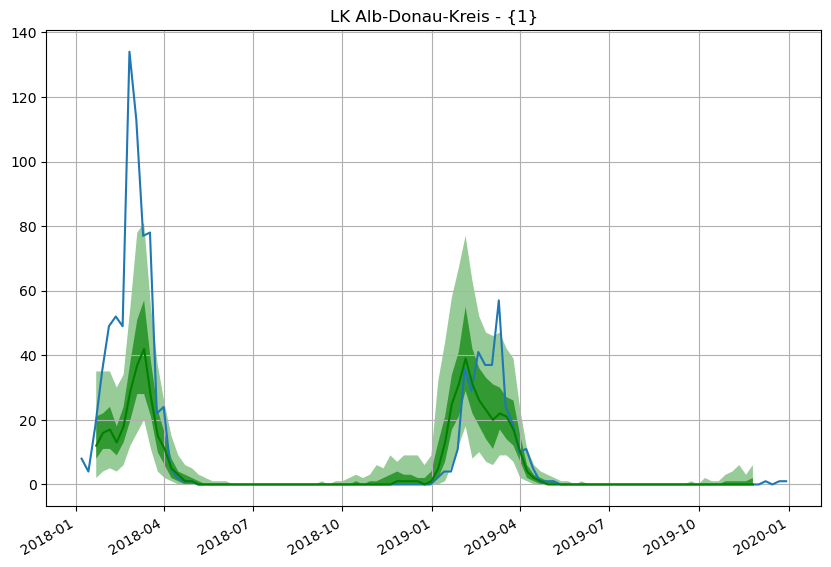

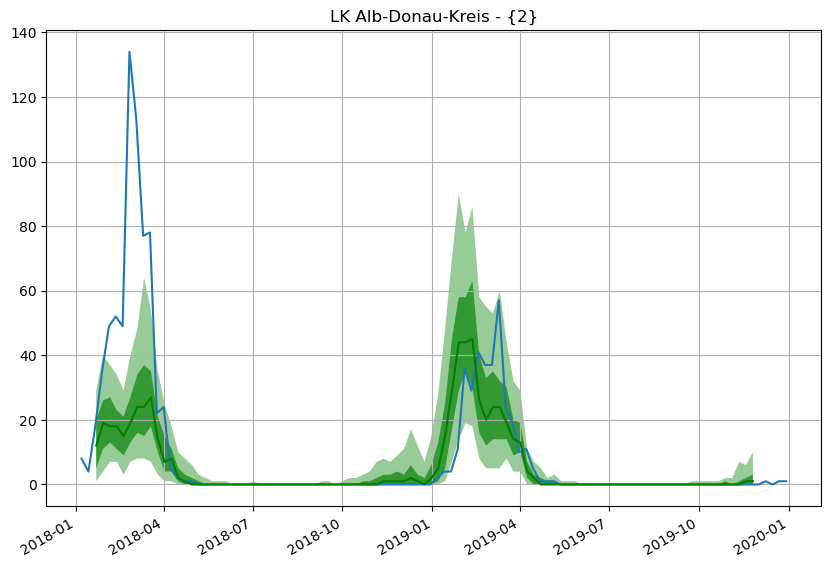

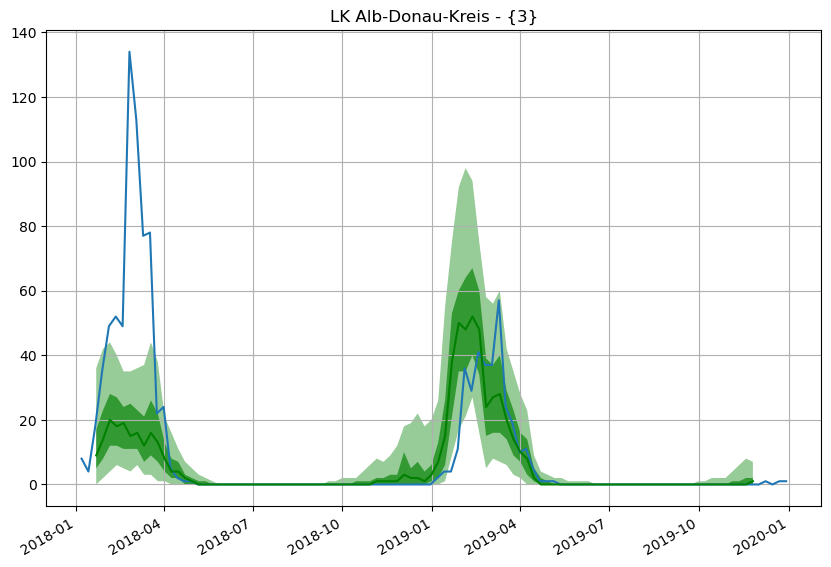

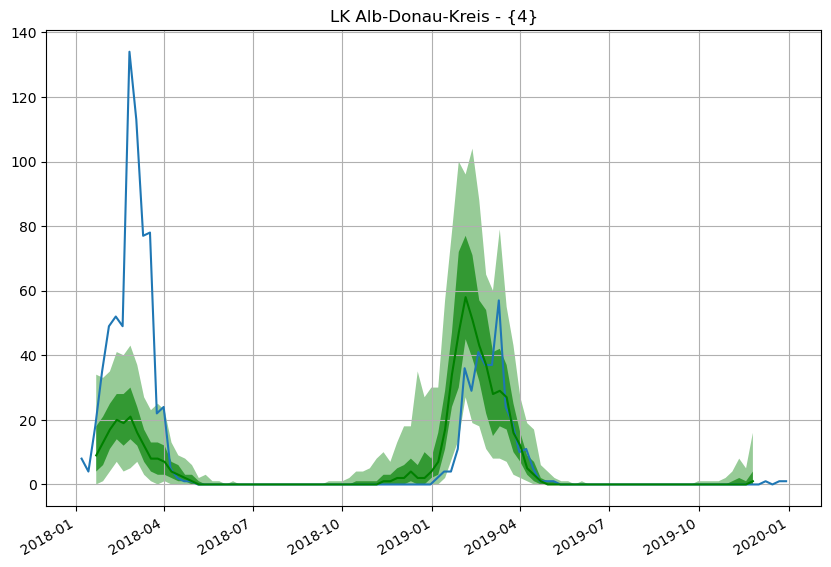

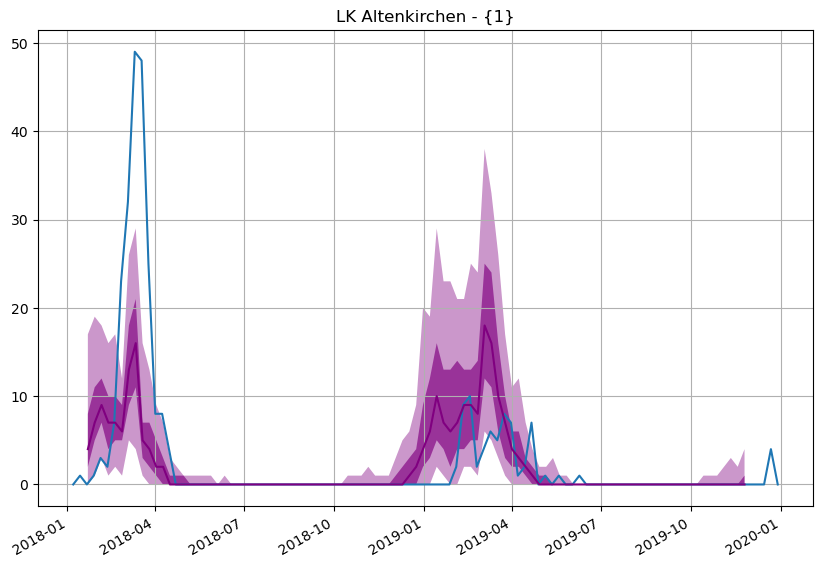

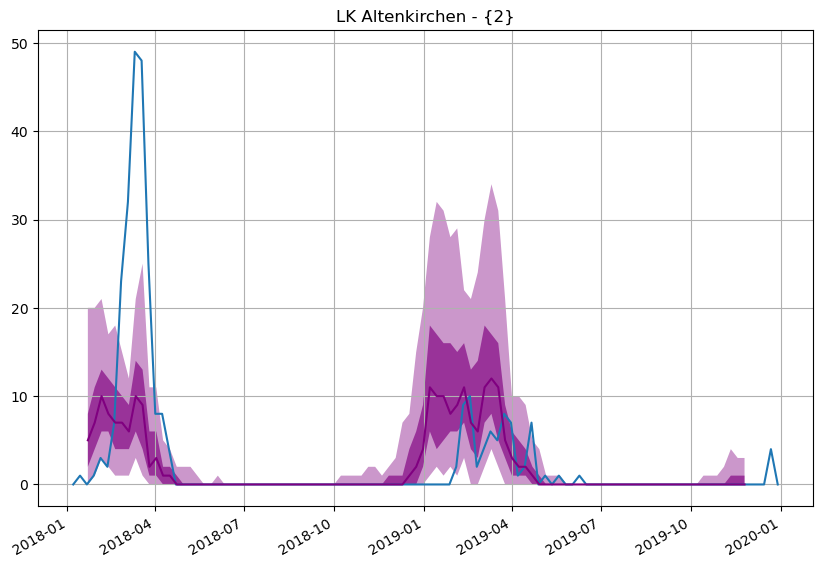

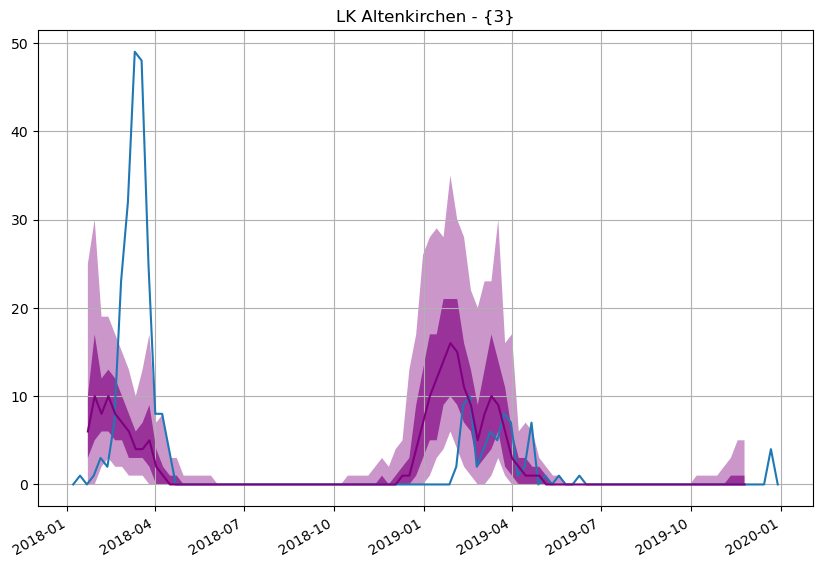

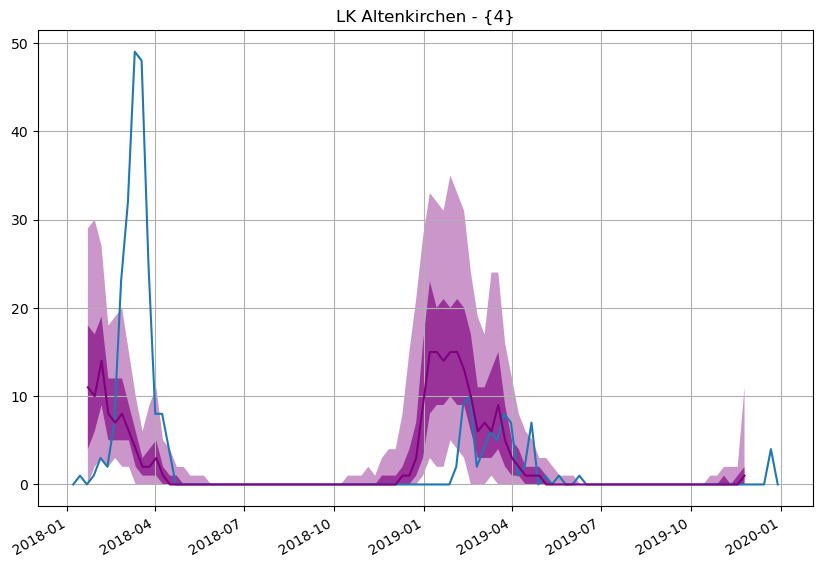

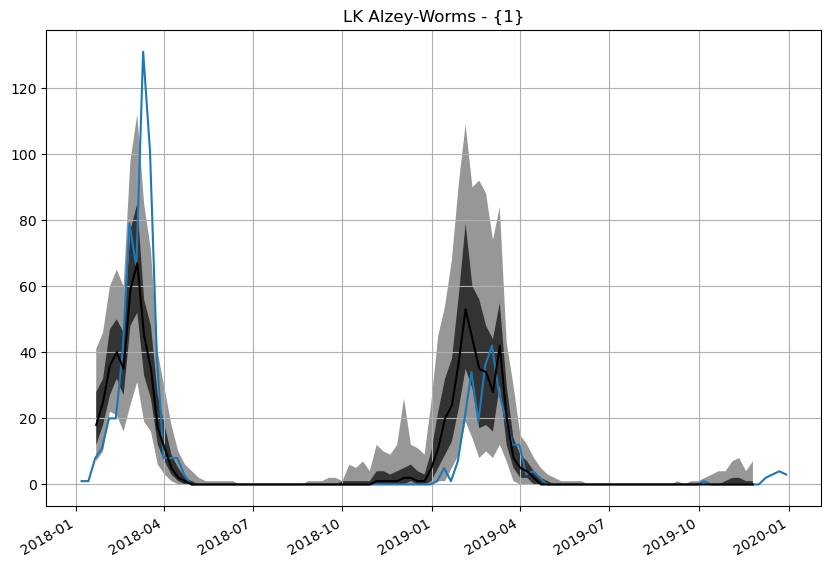

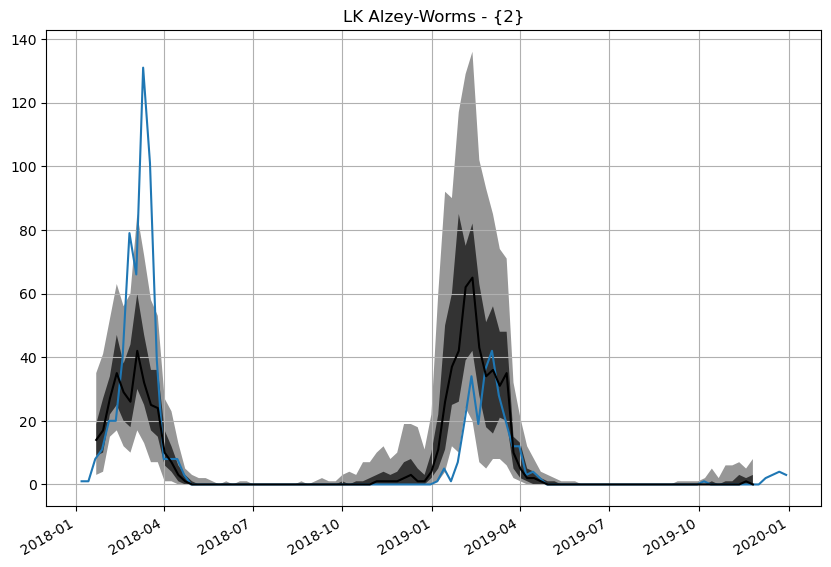

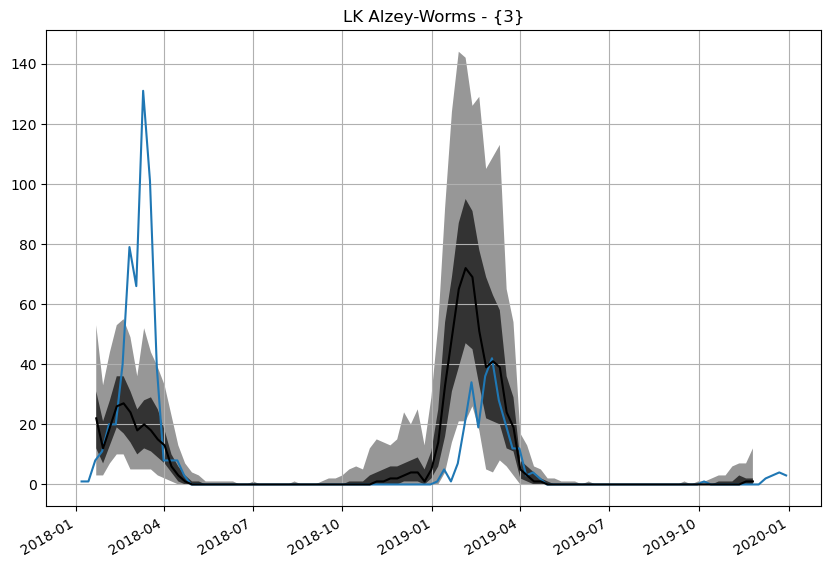

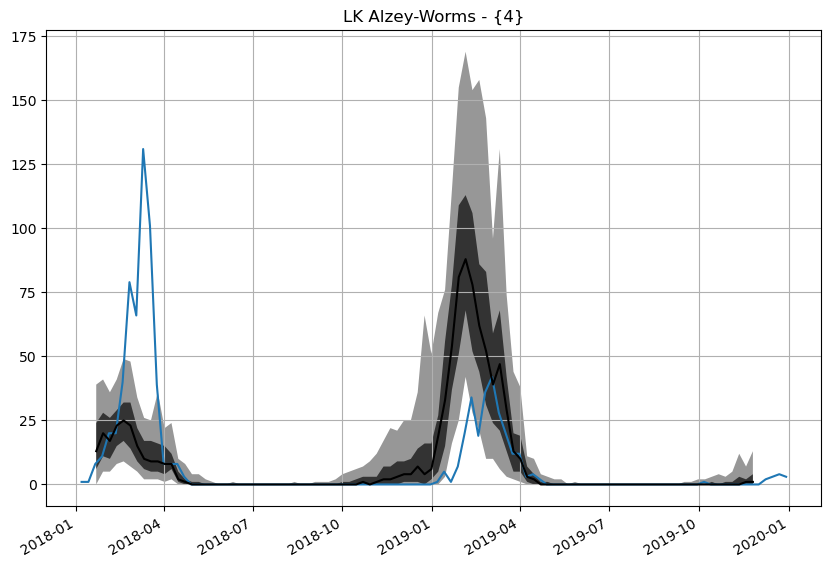

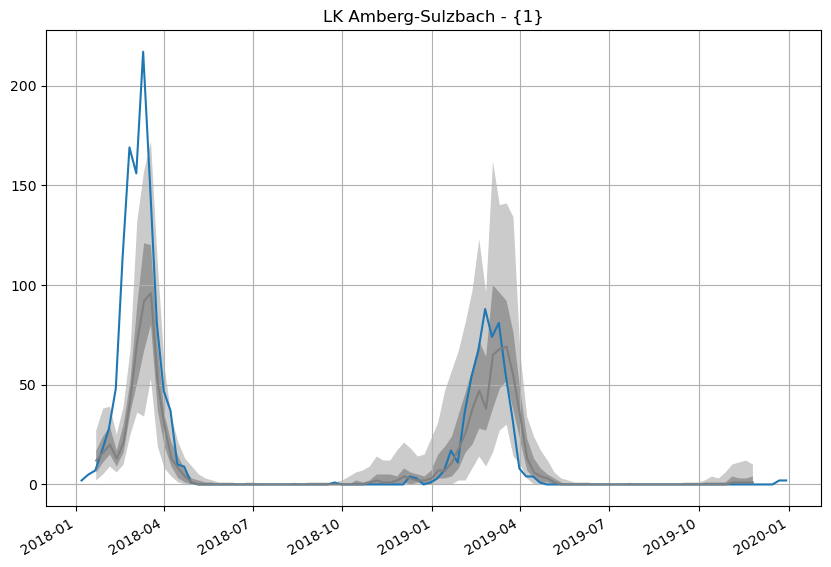

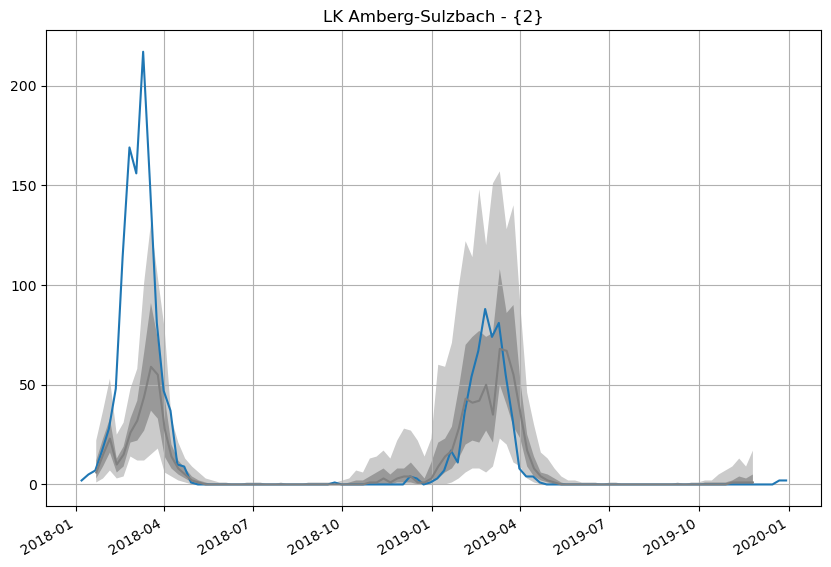

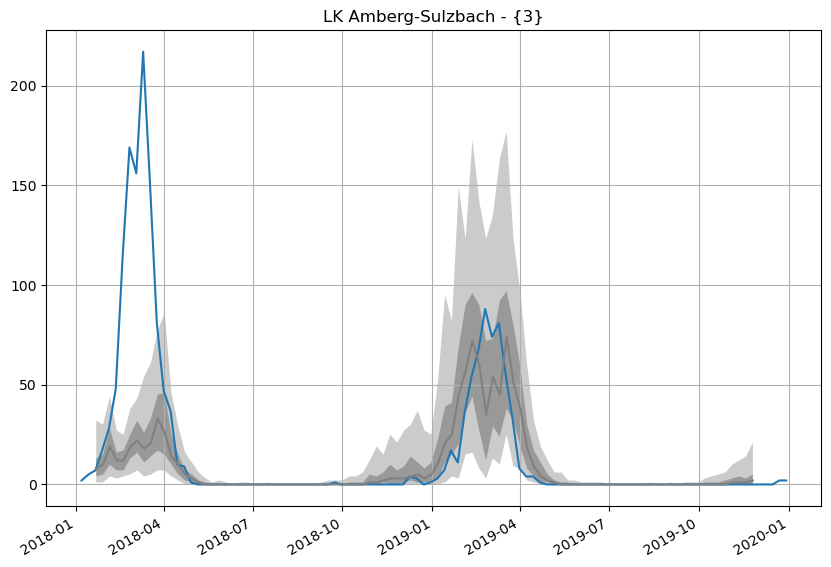

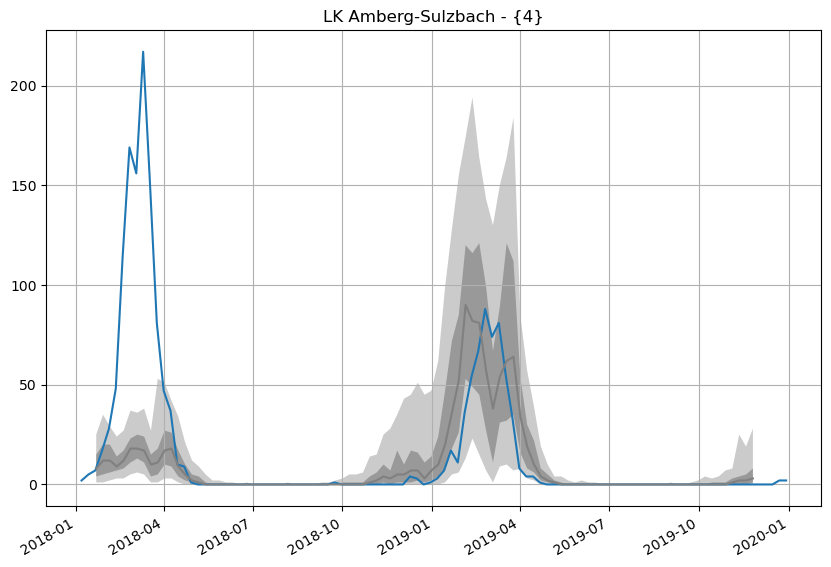

In [8]:
forecast_dict ={1 : one_week_ahead_forecasts,
                2 : two_week_ahead_forecasts,
                3 : three_week_ahead_forecasts,
                4 : four_week_ahead_forecasts}
for location in locations[:4]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

In [9]:
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[3:4]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
print(evaluator_df)

Running evaluation: 411it [00:01, 378.01it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 397.28it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 388.20it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 402.83it/s]


                  item_id         forecast_start          MSE  abs_error  \
8  LK Amberg-Sulzbach {1}  2018-01-22/2018-01-28   419.710615      712.0   
0          aggregated {1}                    NaT   589.360944   247540.0   
8  LK Amberg-Sulzbach {2}  2018-01-22/2018-01-28   749.632088      964.0   
0          aggregated {2}                    NaT  1032.759735   326321.0   
8  LK Amberg-Sulzbach {3}  2018-01-22/2018-01-28  1058.768847     1185.0   
0          aggregated {3}                    NaT  1463.041847   399188.0   
8  LK Amberg-Sulzbach {4}  2018-01-22/2018-01-28  1237.374034     1389.0   
0          aggregated {4}                    NaT  1777.939261   452394.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
8          1637.0        16.876289        1.834975  4.000166  0.767643   
0        528476.0        13.288308        1.452949  4.322325  0.930058   
8          1637.0        16.876289        1.834975  5.415955  1.011125   
0        528476.0  

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])

          item_id       MSE  QuantileLoss[0.025]  QuantileLoss[0.1]  \
0  aggregated {1}   589.361             21944.65            74607.6   
0  aggregated {2}  1032.760             26252.65            92228.8   
0  aggregated {3}  1463.042             32783.55           113617.0   
0  aggregated {4}  1777.939             42361.55           138130.8   

   QuantileLoss[0.5]  QuantileLoss[0.9]  
0           247540.0           199011.6  
0           326321.0           301642.8  
0           399188.0           387479.0  
0           452394.0           439303.6  


In [17]:
config.context_length = 104   # in number of weeks
#config.num_layers = 3
#config.num_cells = 64
#config.cell_type = "lstm"
#config.trainer = Trainer(epochs=4)
#config.distr_output = NegativeBinomialOutput()
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[3:4]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])

100%|██████████| 50/50 [00:06<00:00,  7.99it/s, epoch=4/4, avg_epoch_loss=0.819]
Running evaluation: 411it [00:01, 276.03it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 281.49it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 285.33it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 285.63it/s]


          item_id       MSE  QuantileLoss[0.025]  QuantileLoss[0.1]  \
0  aggregated {1}   590.154             21287.15            70359.4   
0  aggregated {2}  1053.646             23648.30            82274.6   
0  aggregated {3}  1360.522             25125.05            92695.2   
0  aggregated {4}  1550.195             27044.85           100576.2   

   QuantileLoss[0.5]  QuantileLoss[0.9]  
0           227794.0           203559.8  
0           302631.0           319684.0  
0           352296.0           394637.6  
0           387919.0           438172.8  


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [18]:
config.context_length = 4   # in number of weeks
#config.num_layers = 3
#config.num_cells = 64
#config.cell_type = "lstm"
#config.trainer = Trainer(epochs=4)
#config.distr_output = NegativeBinomialOutput()
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[3:4]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])

100%|██████████| 50/50 [00:06<00:00,  7.92it/s, epoch=4/4, avg_epoch_loss=0.838]
Running evaluation: 411it [00:01, 260.73it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 252.69it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 258.74it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 248.52it/s]


          item_id       MSE  QuantileLoss[0.025]  QuantileLoss[0.1]  \
0  aggregated {1}   620.291             20823.95            69750.0   
0  aggregated {2}  1066.836             23985.95            83459.8   
0  aggregated {3}  1459.182             26956.05           100288.0   
0  aggregated {4}  1707.244             32321.50           118519.4   

   QuantileLoss[0.5]  QuantileLoss[0.9]  
0           240841.0           229420.4  
0           315556.0           335362.0  
0           381837.0           411299.0  
0           428649.0           451316.0  


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [19]:
config.context_length = 52   # in number of weeks
config.num_layers = 4
#config.num_cells = 64
#config.cell_type = "lstm"
#config.trainer = Trainer(epochs=4)
#config.distr_output = NegativeBinomialOutput()
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[3:4]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])

100%|██████████| 50/50 [00:06<00:00,  7.95it/s, epoch=4/4, avg_epoch_loss=0.851]
Running evaluation: 411it [00:01, 241.98it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 246.63it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 232.12it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 240.53it/s]


          item_id       MSE  QuantileLoss[0.025]  QuantileLoss[0.1]  \
0  aggregated {1}   569.789             21508.15            71505.0   
0  aggregated {2}   969.734             23476.05            81417.4   
0  aggregated {3}  1267.153             24695.45            88836.0   
0  aggregated {4}  1408.358             25684.85            94683.0   

   QuantileLoss[0.5]  QuantileLoss[0.9]  
0           228569.0           192724.0  
0           293073.0           301402.2  
0           340457.0           379148.2  
0           368858.0           416930.2  


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [21]:
from gluonts.mx import Trainer
df_dict = {}
for context_length in [4, 52, 104]:
    for num_layers in [2, 4, 8]:
        for num_cells in [64, 128, 256]:
            for epochs in [2, 4, 8]:                
                config.context_length = context_length
                config.num_layers = num_layers
                config.num_cells = num_cells
                config.trainer = Trainer(epochs=epochs)
                identifier = f"cl {context_length}, nl {num_layers}, nc {num_cells}, ep {epochs}"
                forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
                split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
                forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
                evaluator = Evaluator(quantiles=config.quantiles)
                evaluator_df = pd.DataFrame()
                for forecast in forecast_dict.values():
                    agg_metrics, item_metrics = evaluator(split_tss, forecast)
                    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
                    for location in locations[3:4]:
                        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
                        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
                    agg_metrics["item_id"] = f"aggregated {d}"
                    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
                df_dict[identifier] = evaluator_df

100%|██████████| 50/50 [00:06<00:00,  7.88it/s, epoch=4/4, avg_epoch_loss=0.873]
Running evaluation: 411it [00:01, 231.44it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 227.78it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 232.94it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 236.22it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

In [22]:
evaluator_df=pd.DataFrame()
for key in df_dict.keys():
    agg_df = df_dict[key]
    agg_df['param'] = str(key)
    evaluator_df = pd.concat([evaluator_df, agg_df])
with pd.option_context('display.max_rows', None,'display.max_columns', None, 'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'param', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])
evaluator_df.to_csv("Evaluation.csv",sep=",")

          item_id                       param       MSE  QuantileLoss[0.025]  \
0  aggregated {1}     cl 4, nl 2, nc 64, ep 2   642.262             21688.50   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 2  1042.687             23160.40   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 2  1403.313             25512.60   
0  aggregated {4}     cl 4, nl 2, nc 64, ep 2  1667.568             27640.35   
0  aggregated {1}     cl 4, nl 2, nc 64, ep 4   762.177             21844.85   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 4  1117.346             23103.75   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 4  1495.873             24340.05   
0  aggregated {4}     cl 4, nl 2, nc 64, ep 4  1720.182             25261.35   
0  aggregated {1}     cl 4, nl 2, nc 64, ep 8   779.663             22334.55   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 8  1147.567             23317.95   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 8  1483.800             24392.55   
0  aggregated {4}     cl 4, nl 2, nc 64,